## Curve fiting of MD of proteins


In [ ]:
# loading the package fastbmdR and libraries 
library(ggplot2)

#install.packages("drc", dependencies = TRUE)

devtools::install_github("jessica-ewald/fastbmdR")

library(fastbmdR)
library(dplyr)
library(knitr)
library(ggplot2)
library(ggforce)
library(arrow)


In [ ]:
## loading parquet file of already ready mahalanobis distances between the compounds and DMSO centroids 


md_data_prot= read_parquet("./outputs/prot_distances.parquet")

md_data_prot = data.frame(md_data_prot)

In [ ]:
## computing the BMD for the mahalanobis distance de CP data

df <- md_data_prot[md_data_prot$Metadata_Compound !=  "UNTREATED",]


models <- c("Exp2", "Exp3", "Exp4", "Exp5", "Poly2", "Lin", "Power", "Hill")

ncpus <- 1

unique_compounds <- unique(df$Metadata_Compound)

feat_cols <- c("gmd", "Metadata_nomic_sample_id")

#colnames(md_data_prot)[!grepl("Metadata", colnames(md_data_prot))]
res <- list()
gene_table <- list()

all_bmd_pass <- data.frame()

for (compound in unique_compounds) {
  
  
  compound_data <- df[df$Metadata_Compound %in% c(compound, "DMSO"), ]
  compound_data$Metadata_compound_concentration[is.na(compound_data$Metadata_compound_concentration)] <- 0


  dose <- compound_data$Metadata_compound_concentration
  dose_log <- dose
  dose_log[dose_log > 0] <- log10(dose_log[dose_log > 0])
  
  rank_dose = unique(dose) %>% sort(. , decreasing = TRUE)
  dose_spacing = abs(log10(rank_dose[2]/rank_dose[1]))
  
  dose_shift = abs(min(dose_log)) + dose_spacing
  dose_shifted = dose_log
  dose_shifted[dose_shifted != 0] = dose_shifted[dose_shifted != 0] + dose_shift
  #print(unique(compound_data$Metadata_compound_concentration))
  if (length(unique(compound_data$Metadata_compound_concentration)) > 2) {  
    
    print(paste("Processing compound:", compound))  
    dose <- dose_shifted
    
    compound_mat <- t(compound_data[, feat_cols])
    #print(head(compound_mat))
    min_val = abs(min(compound_mat, na.rm=TRUE))  
    add_min = min_val + 0.1 * min_val  
    mat_new = compound_mat + add_min  
    
    if (length(dose) == ncol(mat_new)) {  
      tryCatch({
        fit_obj <- PerformCurveFitting(data = mat_new, dose = dose, ncpus = ncpus, models = models)
        fit_obj <- FilterDRFit(fit_obj, lof.pval = 0.1, filt.var = "AIC.model")
        fit_obj <- PerformBMDCalc(fit_obj, ncpus = ncpus, num.sds = 2, bmr.method = "sample.mean", log10.dose = TRUE)
        
        bmd_res <- fit_obj$bmd_res
        bmd_pass <- bmd_res[bmd_res$all.pass, ]
        fit_obj$bmd_pass <- bmd_pass

        res[[compound]] <- fit_obj
        
        if (nrow(bmd_pass) > 0) {
          bmd_pass$compound_name <- compound
          all_bmd_pass <- rbind(all_bmd_pass, bmd_pass) 
        }
      }, error = function(e) {
        print(paste("Error with compound:", compound, "- ignoring this compound"))
      })
    }
  }  
}

In [ ]:
all_bmd_pass <- all_bmd_pass[all_bmd_pass$gene.id == "gmd", ]
print(head(all_bmd_pass))

In [30]:
## calculating the bmd values at real concentration

all_bmd_pass$Concentration <- NA
all_bmd_pass$Concentration_L <- NA
all_bmd_pass$Concentration_U <- NA

for (i in 1:nrow(all_bmd_pass)) {
  compound <- all_bmd_pass$compound_name[i]
  bmd <- all_bmd_pass$bmd[i]
  bmdl <- all_bmd_pass$bmdl[i]
  bmdu <- all_bmd_pass$bmdu[i]
  
  compound_data <- df[df$Metadata_Compound == compound,]
  dose <- compound_data$Metadata_compound_concentration

  dose_log <- dose
  dose_log[dose_log > 0] <- log10(dose_log[dose_log > 0])
  
  rank_dose <- unique(dose)
  rank_dose <- sort(rank_dose, decreasing = TRUE)
  
  if (length(rank_dose) > 1) {
    dose_spacing <- abs(log10(rank_dose[2] / rank_dose[1]))
  } else {
    dose_spacing <- 1
  }
  
  dose_shift <- abs(min(dose_log, na.rm = TRUE)) + dose_spacing
  
  all_bmd_pass$Concentration[i] <- 10^(bmd - dose_shift)
  all_bmd_pass$Concentration_L[i] <- 10^(bmdl - dose_shift)
  all_bmd_pass$Concentration_U[i] <- 10^(bmdu - dose_shift)
}



In [57]:
##  Here we retrieve the curve values to plot them later.
list_plot <- list()  

for (i in 1:nrow(all_bmd_pass)) {  
  tryCatch({
    gene_id <- all_bmd_pass$gene.id[i]
    compound <- all_bmd_pass$compound_name[i]
    
    temp <- plot_bmd_curve(gene_id, res[[compound]], return_type = "plot.data")
    
    temp$protein <- gene_id
    temp$compound <- compound
    #temp$category <- all_bmd_pass$Metadata_Categories[i]
    temp$bmd <- all_bmd_pass$bmd[i]
    temp$bmd_l <- all_bmd_pass$bmdl[i]
    temp$bmd_u <- all_bmd_pass$bmdu[i]
    temp$Concentration <- all_bmd_pass$Concentration[i]
    temp$Concentration_L <- all_bmd_pass$Concentration_L[i]
    temp$Concentration_U <- all_bmd_pass$Concentration_U[i]
    
    list_plot[[i]] <- temp
  }, error = function(e) {
    message(sprintf("Error for gene_id %s and compound %s : %s", gene_id, compound, e$message))
  })
}

final_df_md_prot <- do.call(rbind, list_plot)


kable(head(final_df_md_prot))




|  x| Observations|       f_x|protein |compound  |     bmd|    bmd_l|    bmd_u| Concentration| Concentration_L| Concentration_U|
|--:|------------:|---------:|:-------|:---------|-------:|--------:|--------:|-------------:|---------------:|---------------:|
|  0|       0.5322| 0.5753096|gmd     |Bevirimat | 4.44786| 4.405024| 4.487468|      140.2265|        127.0555|        153.6164|
|  0|       1.1392| 0.5753096|gmd     |Bevirimat | 4.44786| 4.405024| 4.487468|      140.2265|        127.0555|        153.6164|
|  0|       0.5782| 0.5753096|gmd     |Bevirimat | 4.44786| 4.405024| 4.487468|      140.2265|        127.0555|        153.6164|
|  0|       0.8172| 0.5753096|gmd     |Bevirimat | 4.44786| 4.405024| 4.487468|      140.2265|        127.0555|        153.6164|
|  0|       0.5792| 0.5753096|gmd     |Bevirimat | 4.44786| 4.405024| 4.487468|      140.2265|        127.0555|        153.6164|
|  0|       0.4792| 0.5753096|gmd     |Bevirimat | 4.44786| 4.405024| 4.487468|      140.2265| 

In [ ]:
## we now plot the bmd curves for each compound and protein and save them in a pdf file

## NO NEED TO RE-RUN

n_per_page <- 9  



plot_groups <- unique(final_df_md_prot$compound)
n_pages <- ceiling(length(plot_groups) / n_per_page)


pdf_file <- "./outputs/bmd_curves_MD_proteins.pdf"
pdf(pdf_file, width = 15, height = 10)

for (i in 1:n_pages) {
  tryCatch({
    p <- ggplot(final_df_md_prot, aes(x = x, y = Observations)) +
      geom_point(show.legend = FALSE) +
      geom_line(aes(y = f_x), show.legend = FALSE) +

      geom_vline(aes(xintercept = bmd), linetype = "solid", color = "red") +  
      geom_vline(aes(xintercept = bmd_l), linetype = "dashed", color = "red") + 
      geom_vline(aes(xintercept = bmd_u), linetype = "dashed", color = "red") +  
      facet_wrap_paginate(~ compound, ncol = 3, nrow = 3, page = i, scales = "free_y") +
      
      labs(title = sprintf("BMD curves MD proteins", i),
           x = "Concentration",
           y = "Observation") +
      theme_bw() +
      theme(strip.text = element_text(size = 8))
    
    print(p) 
  }, error = function(e) {
    message(sprintf("Error in the page %d : %s", i, e$message))
  })
}
dev.off()


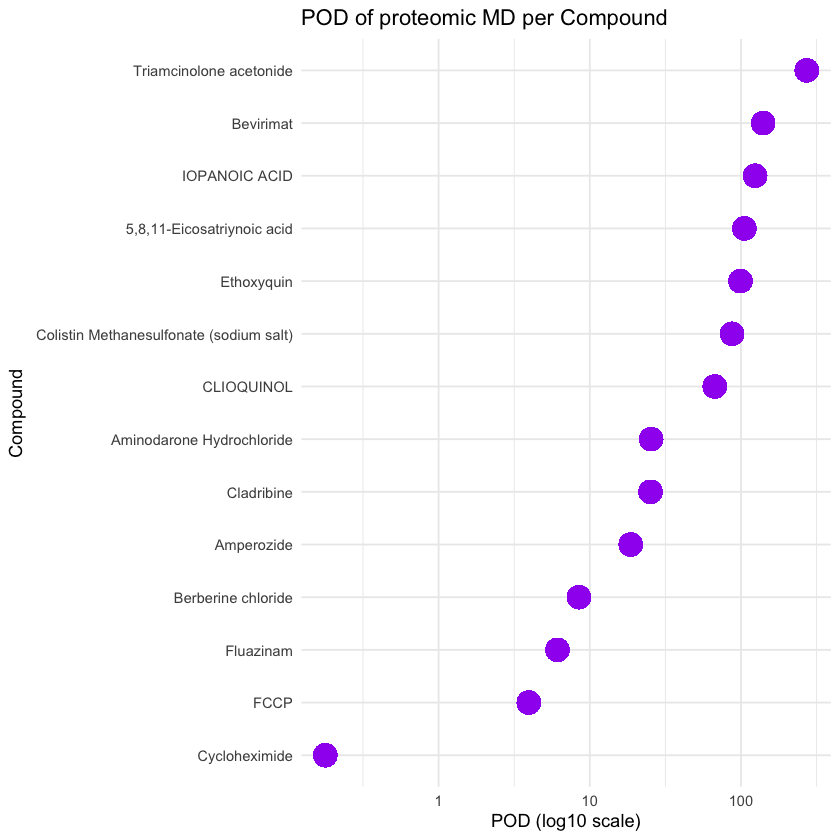

In [58]:
### scatter of POD values 


ggplot(final_df_md_prot, aes(x = Concentration, y = reorder(compound, Concentration ))) +
  geom_point(color = "purple", alpha = 3,  size = 6) +
  scale_x_continuous(
    trans = "log10",
    breaks = c(0.001, 0.01, 0.1, 1, 10, 100),
    labels = c("0.001", "0.01", "0.1", "1", "10", "100")
  ) +
  scale_size_continuous(range = c(2, 8)) + 
  labs(title = "POD of proteomic MD per Compound",
       x = "POD (log10 scale)",
       y = "Compound") +
  theme_minimal()



In [61]:
print(unique(final_df_md_prot$compound))

 [1] "Bevirimat"                              
 [2] "Ethoxyquin"                             
 [3] "Amperozide"                             
 [4] "IOPANOIC ACID"                          
 [5] "5,8,11-Eicosatriynoic acid"             
 [6] "Cycloheximide"                          
 [7] "CLIOQUINOL"                             
 [8] "Berberine chloride"                     
 [9] "Triamcinolone acetonide"                
[10] "Cladribine"                             
[11] "FCCP"                                   
[12] "Aminodarone Hydrochloride"              
[13] "Colistin Methanesulfonate (sodium salt)"
[14] "Fluazinam"                              


In [60]:
## fusioning the results of proteomic data and MD distance from CP data


#bmd_table= read.csv('./outputs/proteomic_bmd_dose_results_10th_perc.csv', sep= ',')

#merged_table <- merge(pod_summary, bmd_table, by = "compound", all = TRUE)

#print(merged_table)

#write.csv(merged_table, "./outputs/proteomic_and_MD_10th_perc.csv", row.names = FALSE)

write.csv(final_df_md_prot, "./outputs/results_MD_prot.csv", row.names = FALSE)

### Comparing the 10th Percentile of protein PODs and MD POD

In [12]:
library(patchwork)

## loading the results of MD PODs

final_df_md <- read.csv("./outputs/results_MD_CP_data.csv", header = TRUE)


final_df_md_prot <- read.csv("./outputs/results_MD_prot.csv", header = TRUE)

final_df_prot <- read.csv("./outputs/results_POD_prot.csv", header = TRUE)

final_df_cp <- read.csv("./outputs/results_POD_CP_data_10_perc.csv", header = TRUE)

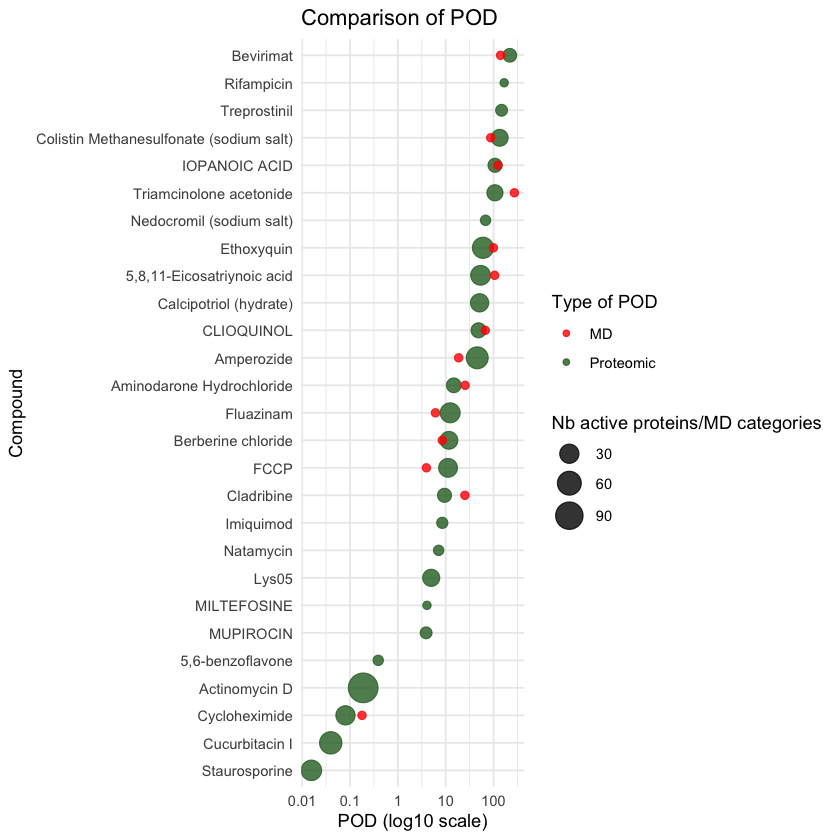

In [7]:
pod_summary_proteins <- final_df_prot %>%
  group_by(compound) %>%
  summarise(
    pod_10th_percentile = quantile(Concentration, probs = 0.10, na.rm = TRUE),
    nb_proteins = n_distinct(protein),
    .groups = "drop"
  ) %>%
  mutate(type = "Proteomic")


pod_summary_md <- final_df_md_prot %>%
  group_by(compound = compound) %>%
  summarise(
    pod_10th_percentile = unique(Concentration),
    nb_proteins = 1 
  ) %>%
  mutate(type = "MD")

pod_summary_combined <- bind_rows(pod_summary_proteins, pod_summary_md)

compound_order <- pod_summary_combined %>%
  filter(type == "Proteomic") %>%
  arrange(pod_10th_percentile) %>%
  pull(compound)


ggplot(pod_summary_combined, aes(x = pod_10th_percentile, y = factor(compound, levels = compound_order))) +
  geom_point(aes(color = type, size = nb_proteins), alpha = 0.8) +
  scale_x_continuous(
    trans = "log10",
    breaks = c(0.001, 0.01, 0.1, 1, 10, 100),
    labels = c("0.001", "0.01", "0.1", "1", "10", "100")
  ) +
  scale_color_manual(values = c("Proteomic" = "#2b6c2b", "MD" = "red")) +
  scale_size_continuous(range = c(2, 8)) +
  labs(
    title = "Comparison of POD",
    x = "POD (log10 scale)",
    y = "Compound",
    color = "Type of POD",
    size = "Nb active proteins/MD categories"
  ) +
  theme_minimal()


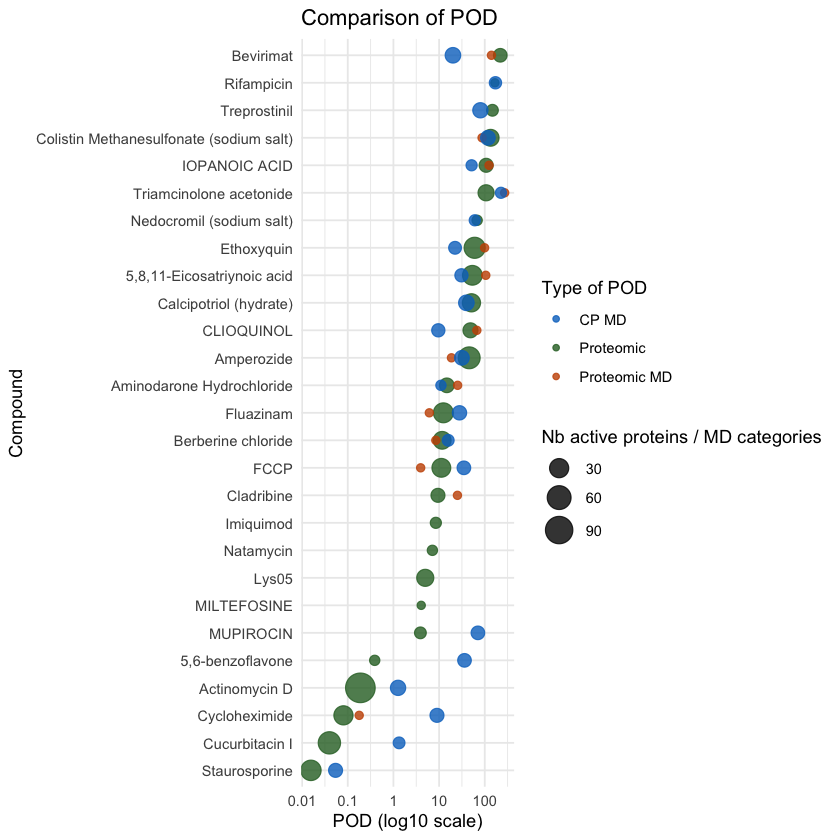

In [8]:
pod_summary_proteins <- final_df_prot %>%
  group_by(compound) %>%
  summarise(
    pod_10th_percentile = quantile(Concentration, probs = 0.10, na.rm = TRUE),
    nb_proteins = n_distinct(protein),
    .groups = "drop"
  ) %>%
  mutate(type = "Proteomic")

pod_summary_md <- final_df_md_prot %>%
  group_by(compound) %>%
  summarise(
    pod_10th_percentile = unique(Concentration),
    nb_proteins = 1,  # Pour éviter les NA
    .groups = "drop"
  ) %>%
  mutate(type = "Proteomic MD")

pod_summary_cp <- final_df_md %>%
  group_by(compound) %>%
  summarise(
    pod_10th_percentile = quantile(Concentration, probs = 0.10, na.rm = TRUE),
    nb_proteins = n_distinct(protein),
    .groups = "drop"
  ) %>%
  mutate(type = "CP MD")

pod_summary_combined <- bind_rows(pod_summary_proteins, pod_summary_md, pod_summary_cp)

compound_order <- pod_summary_combined %>%
  filter(type == "Proteomic") %>%
  arrange(pod_10th_percentile) %>%
  pull(compound)

ggplot(pod_summary_combined, aes(x = pod_10th_percentile, y = factor(compound, levels = compound_order))) +
  geom_point(aes(color = type, size = nb_proteins), alpha = 0.8) +
  scale_x_continuous(
    trans = "log10",
    breaks = c(0.001, 0.01, 0.1, 1, 10, 100, 1000),
    labels = c("0.001", "0.01", "0.1", "1", "10", "100", "1000")
  ) +
  scale_color_manual(values = c(
    "Proteomic" = "#2b6c2b",
    "Proteomic MD" = "#c75200",
    "CP MD" = "#0073c7"
  )) +
  scale_size_continuous(range = c(2, 8)) +
  labs(
    title = "Comparison of POD",
    x = "POD (log10 scale)",
    y = "Compound",
    color = "Type of POD",
    size = "Nb active proteins / MD categories"
  ) +
  theme_minimal()

In [15]:
print(head(final_df_cp))

                                 compound pod_10th_percentile_cp nb_features
1 Colistin Methanesulfonate (sodium salt)            122.7551672         185
2              5,8,11-Eicosatriynoic acid             25.8002609         157
3                           Actinomycin D              0.7816129         106
4                              CLIOQUINOL             19.0267673         103
5                  Calcipotriol (hydrate)             50.4275796         100
6                           Staurosporine              0.3806492          97


Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_density()`)."
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
"Removed 14 rows containing missing values"
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
"Removed 6 rows containing missing values"
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
"Removed 5 rows containing missing values"
Warning message:
"Removed 14 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 14 rows containing non-finite outside the scale range
(`stat_density()`)."
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
"Removed 15 rows containing missing values"
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
"Removed 15 rows containing missing values"
Warning message:
"Removed 6 rows containing 

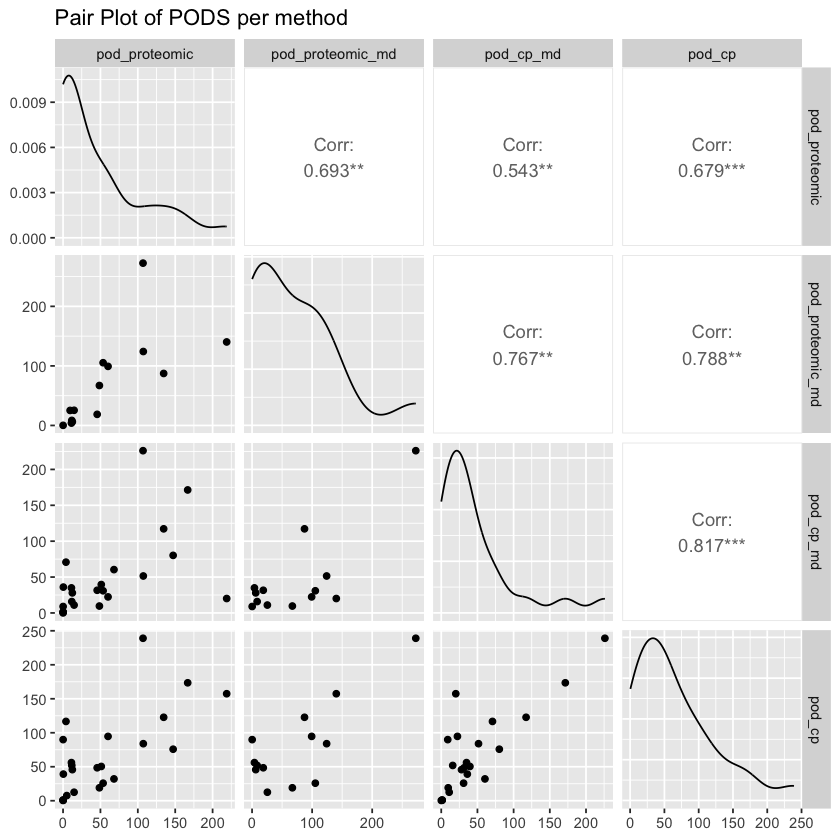

In [18]:
library(GGally)


prot_renamed <- pod_summary_proteins %>%
  select(compound, pod_proteomic = pod_10th_percentile)

md_renamed <- pod_summary_md %>%
  select(compound, pod_proteomic_md = pod_10th_percentile)

cp_renamed <- pod_summary_cp %>%
  select(compound, pod_cp_md = pod_10th_percentile)

cp_renamed_2 <- final_df_cp %>%
  select(compound, pod_cp = pod_10th_percentile_cp)


merged_pods <- prot_renamed %>%
  full_join(md_renamed, by = "compound") %>%
  full_join(cp_renamed, by = "compound")%>%
  full_join(cp_renamed_2, by = "compound")


#print(merged_pods)
ggpairs(
  merged_pods %>% select(-compound),
  title = "Pair Plot of PODS per method"
)

